In [163]:
import pandas as pd
import numpy as np

#for text pre-processing
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

import seaborn as sns
import matplotlib.pyplot as plt

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec

In [164]:
df_train = pd.read_csv('nlp-getting-started/train.csv')
df_test = pd.read_csv('nlp-getting-started/test.csv')

In [165]:
df_train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


0    4342
1    3271
Name: target, dtype: int64


C:\Users\abhil\anaconda3\envs\KerasPython37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


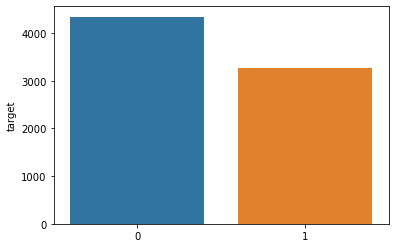

In [166]:
x = df_train['target'].value_counts()
print(x)
sns.barplot(x.index,x)

In [167]:
# Missing values

df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [168]:
# Number of words in a tweet:

df_train['word_count'] = df_train['text'].apply(lambda x : len(str(x).split()))

# disaster tweets
print(df_train[df_train['target'] == 1]['word_count'].mean())

#Non disaster tweets
print(df_train[df_train['target'] == 0]['word_count'].mean())

15.167532864567411
14.704744357438969


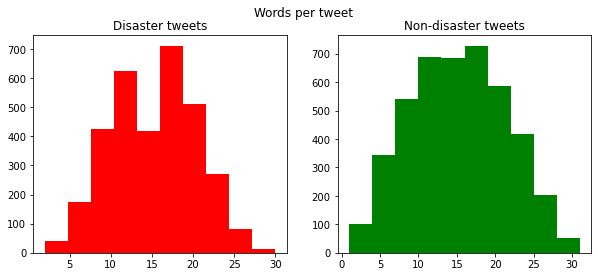

In [169]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['target']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Disaster tweets')
train_words=df_train[df_train['target']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Words per tweet')
plt.show()

In [170]:
# char count
df_train['char_count'] = df_train['text'].apply(lambda x : len(str(x)))

# disaster tweets
print(df_train[df_train['target'] == 1]['char_count'].mean())

#Non disaster tweets
print(df_train[df_train['target'] == 0]['char_count'].mean())

108.11342097217977
95.70681713496084


### Text preprocessing 

In [171]:
# Simple text cleaning processes
# Stop-word removal
# Stemming
# Lemmatization

#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower()
    text = text.strip()
    text = re.compile('<.*?>').sub('',text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ',text) # replace %s with string punctuation
    text = re.sub('\s+',' ',text) #Matches any whitespace char
    text = re.sub(r'\[[0-9]*\]',' ',text) # Digits which are continuos are not removed ex 1234
    text = re.sub(r'[^\w\s]',' ',text.lower().strip()) # \w - matches alphanumeric chars - [a-zA-Z0-9_],\s - matches whitespace chars
    text = re.sub(r'\d',' ',text) # Matches any decimal digit, this is equivalent to the set class [0-9]
    text = re.sub(r'\s+',' ',text) # after removing digis we need to remove space once again
    return text
 
# STOPWORD REMOVAL
def stopword(string):
    stopword = [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(stopword)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()

# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [172]:
def finalPreProcess(string):
       return lemmatizer(stopword(preprocess(string)))

df_train['clean_text'] = df_train['text'].apply(lambda x : finalPreProcess(x))

df_train.head(5)

,id,keyword,location,text,target,word_count,char_count,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,133,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,get sent photo ruby alaska smoke wildfires pou...


### 4.Extracting vectors from text (Vectorization)

In [173]:
# The process to convert text data into numerical data/vector, is called vectorization or in the NLP world, word embedding

X_train, X_test, y_train, y_test = train_test_split(df_train['clean_text'], df_train['target'], test_size = 0.2, shuffle = True)

print(X_train.shape)
print(X_train)
#Word2Vec
# Word2Vec runs on tokenized sentences

x_train_tok = [nltk.word_tokenize(i) for i in X_train]
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

(6090,)
6415    http co k tqsaarm suicide bomber kill saudi se...
100     norwaymfa bahrain police previously die road a...
2776    health newyear anniversary devastation work fi...
2694    ignition knock detonation sensor connector con...
4795    sw train strange loud impact bang noise train ...
                              ...                        
6187    connor franta damn siren hope everyone okay da...
3352    ahrar al sham negotiation iran al zabadani wan...
4293    hellfire ûªt even want think mention let ûªs a...
5279    california spring oil spill estimate grows ass...
5165    wwe k universe mode part obliterate http co om...
Name: clean_text, Length: 6090, dtype: object


In [174]:
# TF-IDF

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)
print(X_train_vectors_tfidf)

X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

  (0, 12913)	0.36575603578444144
  (0, 10202)	0.337653724333346
  (0, 4458)	0.3047761275683909
  (0, 12264)	0.2766738161172954
  (0, 9471)	0.26023501773481783
  (0, 13280)	0.26853801099372887
  (0, 12960)	0.26335525425639017
  (0, 12813)	0.254633979531177
  (0, 7862)	0.19589458970906046
  (0, 1544)	0.23690799159758213
  (0, 13961)	0.21053117737590532
  (0, 14779)	0.36575603578444144
  (0, 2532)	0.13297464392269553
  (0, 6497)	0.13587868833579425
  (1, 5489)	0.4005482974169867
  (1, 4564)	0.2664423588879372
  (1, 67)	0.23621162501875265
  (1, 12429)	0.27885584101702854
  (1, 3501)	0.24736990855200902
  (1, 11377)	0.3825457709800392
  (1, 11210)	0.22302941257913186
  (1, 1010)	0.4005482974169867
  (1, 10070)	0.4005482974169867
  (1, 7862)	0.21452891190948623
  (1, 2532)	0.0728118773332509
  :	:
  (6088, 3201)	0.3559612461948539
  (6088, 16939)	0.3559612461948539
  (6088, 775)	0.31980685171952805
  (6088, 5807)	0.3286115025778181
  (6088, 10225)	0.3286115025778181
  (6088, 11361)	0.276458

In [ ]:
#building Word2Vec model
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
def fit(self, X, y):
        return self
def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
w2v = dict(zip(model.wv.index2word, model.wv.syn0)) 
df['clean_text_tok']=[nltk.word_tokenize(i) for i in df['clean_text']]
model = Word2Vec(df['clean_text_tok'],min_count=1)     
modelw = MeanEmbeddingVectorizer(w2v)

# converting text to numerical data using Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_test_tok)

#### 5.Running ML algorithms